In [5]:
import numpy as np #array
import pandas as pd #data set
import yfinance as yf #api table
import matplotlib.pyplot as plt #graph visualization

import torch
import torch.nn as nn #build
import torch.optim as optim #train

from sklearn.preprocessing import StandardScaler #scale
from sklearn.metrics import root_mean_squared_error #evaluate

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
ticker = 'VOO'
df = yf.download(ticker, '2024-08-01')

C:\Users\ptul0\AppData\Local\Temp\ipykernel_26260\3435310976.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2024-08-01')
[*********************100%***********************]  1 of 1 completed


In [25]:
df

Price,Close,High,Low,Open,Volume
Ticker,VOO,VOO,VOO,VOO,VOO
Date,,,,,
2024-08-01,492.658478,503.389687,489.420357,501.355991,6939200
2024-08-02,483.654907,487.218801,479.597367,486.122988,8561200
2024-08-05,469.132721,475.036350,462.903289,464.166945,15244300
2024-08-06,473.812225,480.643855,469.863297,471.294795,8255000
2024-08-07,470.524719,482.312274,470.031103,479.498686,5976400
...,...,...,...,...,...
2025-08-05,577.349976,581.500000,576.400024,580.789978,4647400
2025-08-06,581.640015,582.270020,577.409973,578.250000,4545000


<Axes: xlabel='Date'>

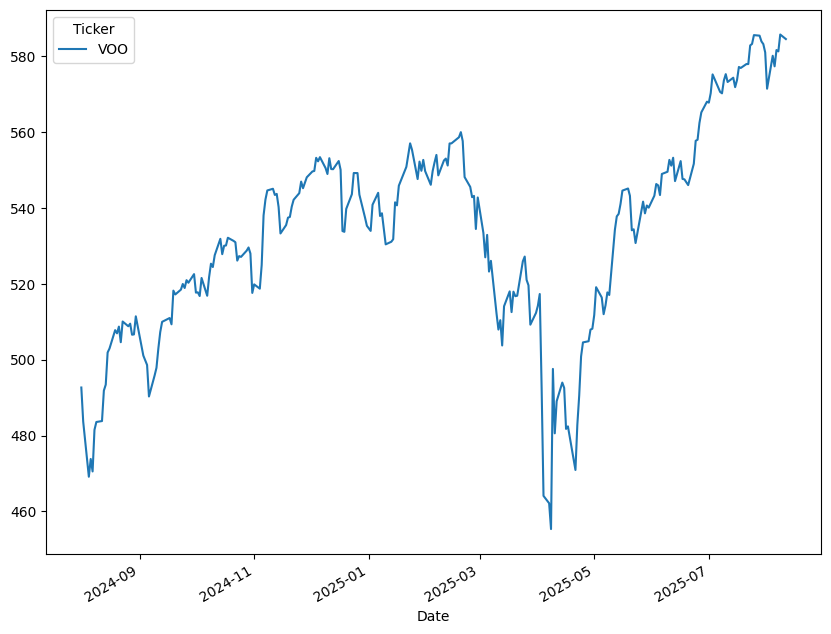

In [26]:
df.Close.plot(figsize=(10,8))

In [15]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [ ]:
df.close #standard deviation of 1, mean of 0

Ticker,VOO
Date,
2024-08-01,-1.488221
2024-08-02,-1.822712
2024-08-05,-2.362223
2024-08-06,-2.188375
2024-08-07,-2.310510
...,...
2025-08-05,1.658139
2025-08-06,1.817518
2025-08-07,1.804514
